## Make your own polarized inversion code

In this section, we are going to use the forward calculation module of pyMilne by Jaime de la Cruz Rodriguez to devise our own polarized inversion code, the same way we did for the scalar problem yesterday. 

Remember, the steps are:

1) Make the function that takes the model parameters as one array, and then as much arguments as you need. 

2) Use it to make merit function ($\chi^2$)

3) Use a minimization routine to do find the best fit. 

4) Alternatively, you can use a curve-fitting routine directly on the function. 

#### Let's go! 

In [1]:
# We are starting the same way as before:
# Some common imports:
# This will allow us to calculate and plot thins. 
import MilneEddington 
import numpy as np
import emcee, corner
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'MilneEddington'

Again, we are going to calculate the "forward problem", that is synthesize some spectra, and then try to fit them.

In [80]:
# This defines the range of wavelengths we are dealing with
regions = [[np.arange(1001, dtype='float64')*0.002 + 6301.0, None]]

# This defines which lines are taken into account, by their names (take a look at MilneEddington.py)
lines   = [6301,6302]

In [81]:
# Here we define an object (object is basically a variable that can do functions too)
# Object knows about the lines, wavelength grid, and even about number of threads, since we can calculate
# many spectral in parallel :) We will have to pass this object to our minimization function too! 
# We are not setting nthreads=1, because we will always be calculating one spectrum at the time

me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

pyMilne::dealloc: cleaning-up...


In [82]:
# The next step is wrapping up model in one function so we can use other routines meant 
# to work with these
def me_fwd(parameters, mu, me):
    model = parameters.reshape(1,1,len(parameters))
    syn = me.synthesize(model,mu = mu)
    return syn[0,0]

Text(0, 0.5, 'V')

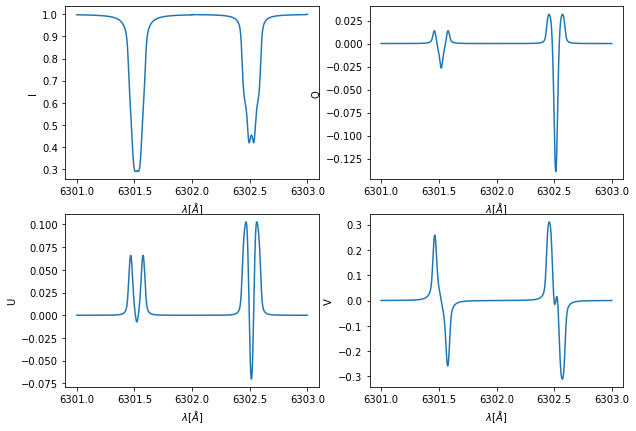

In [83]:
# Now let's test whether this works:

# '|B| [G]', 'inc [rad]', 'azi [rad]', 'vlos [km/s]', 'vDop [Angstrom]', 'eta_l', 'damping', 'S0', 'S1'
model_in = np.float64([1000., np.pi/4., np.pi/6., 1.0, 0.02, 30., 0.1, 0.2, 0.8])
ll = np.squeeze(regions[0])[0]

syn = me_fwd(model_in, 1.0, me)

plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll,syn[0])
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll,syn[1])
plt.subplot(223)
plt.plot(ll,syn[2])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll,syn[3])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")


#### Looks good! Now let's move on and calculate $\chi^2$

In [84]:
def chi2(parameters,stokes,errors,mu,me):
    # First calculate model values:
    stokes_model = me_fwd(parameters,mu,me)
    
    #Then the difference between the observed and calculated - the residual
    residual = stokes - stokes_model
    
    residual /= errors
    
    residual = residual**2.0
    
    return np.sum(residual)

In [85]:
# the easiest way to see if this makes sense is to calculate the chisquared for te 
# original model and see if it is zero
print (chi2(model_in,syn,1E-3,1.0,me))

0.0


Yes, it basically is, great! 

#### Our next task now is to start from a different model and use optimize.minimize to find a good fit.

In [86]:
from scipy.optimize import minimize

In [87]:
# Let's initiate a guess model
model_guess = np.float64([500.0,np.pi/6.,np.pi/4.,0.,0.025,50.,0.05,0.6,0.4])

# Try if it is good:
print ("Guess Chi2= ", chi2(model_guess,syn,1E-3,1.0,me))
# It's not!

Guess Chi2=  15655234.669077419


In [88]:
# Starting from the guess model, we look for the model that minimizes chisqared
result = minimize(chi2,model_guess,args=(syn,1E-3,1.0,me))
print (result.x)

[5.00000008e+02 5.22137829e-01 7.85133217e-01 1.40730939e-02
 3.67139239e-02 5.00000269e+01 2.81209268e-02 5.22096739e-01
 4.50094948e-01]


Text(0, 0.5, 'V')

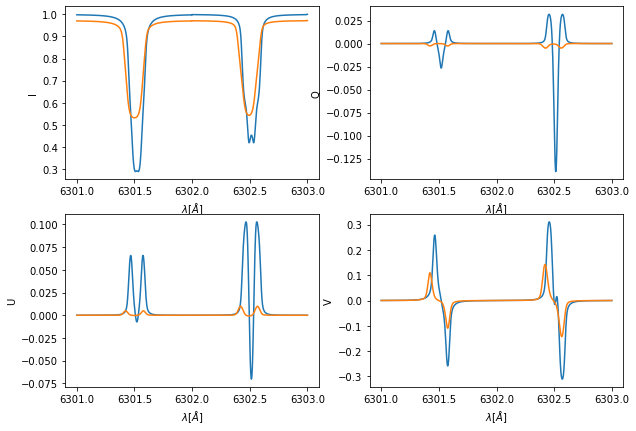

In [89]:
# Does not look good by eye, let's see...

fit = me_fwd(result.x,1.0,me)

plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll,syn[0])
plt.plot(ll,fit[0])
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll,syn[1])
plt.plot(ll,fit[1])
plt.subplot(223)
plt.plot(ll,syn[2])
plt.plot(ll,fit[2])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll,syn[3])
plt.plot(ll,fit[3])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")


### This did not really work. 

Whether the minimization routine will find a good (true?!) minimum depends on a plethora of things, and these are (and we will talk about them all):

1) The initial guess might be too far from the real $\chi^2$, thus the code is unable to get ther 

2) The minimization method as such can have the problem with such a shape of the $\chi^2$ hypersurface, or simply needs to many iterations to converge

3) The problem might be denegerate - not the case here

4) The model (meaning the equations, not the values of the parameters) might be inadequate - not the case here, we are fitting the data that is generated with the same model we are using to fit 

### Let's spend some time playing with this and eventually we will find...

In [90]:
# A better solution:

# Start closer to the good solution (how can we do this?)
model_guess = np.float64([1300.0,np.pi/6.,np.pi/4.,0.,0.025,50.,0.05,0.7,0.3])
print (chi2(model_guess,syn,1E-3,1.0,me))

# Use a more robust method:
result = minimize(chi2,model_guess,args=(syn,1E-3,1.0,me),method='Nelder-Mead')

# Use more iterations (the most easily accompplished by just repeating the minimization once again from 
# the result of the pervious one)
result = minimize(chi2,result.x,args=(syn,1E-3,1.0,me),method='Nelder-Mead')

print (result.x)


19862184.518694796
[9.45874261e+02 7.34826170e-01 5.23202674e-02 1.00681024e+00
 2.22721383e-02 2.79058326e+01 8.26004882e-02 2.18462554e-01
 7.80638282e-01]


Text(0, 0.5, 'V')

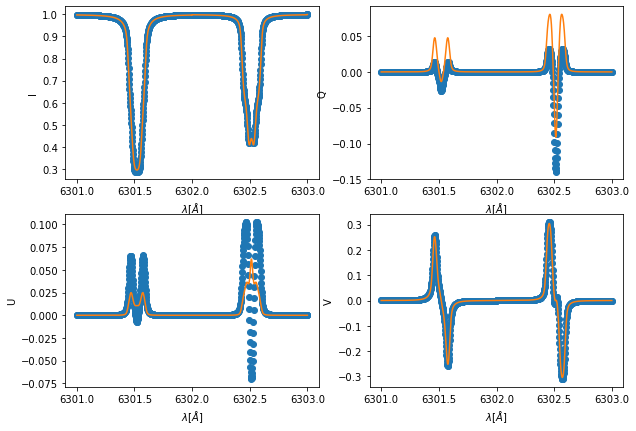

In [91]:
fit = me_fwd(result.x,1.0,me)

plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll,syn[0],'o')
plt.plot(ll,fit[0])
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll,syn[1],'o')
plt.plot(ll,fit[1])
plt.subplot(223)
plt.plot(ll,syn[2],'o')
plt.plot(ll,fit[2])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll,syn[3],'o')
plt.plot(ll,fit[3])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")

#### Looks much better! 

Now, a reasonable question would be. Is there a package that can do this for us even easier. 

Yes there is, Jaime de la Cruz Rodriguez, in addition to the synthesis module also made a very nice fitting one. 

#### In spectropolarimetric world, we call this fitting "spectropolarimetric inversion"

Let's see how the module works

In [94]:
model_guess = np.float64([1300.0,np.pi/6.,np.pi/4.,0.,0.025,50.,0.05,0.7,0.3])
model_guess = model_guess.reshape(1,1,9) # This is because the code can simultaneously invert many pixels
noise = np.zeros([4,1001])
noise[:,:] = 1
syn = syn.reshape(1,1,4,1001)
    
#
# This is where the inversion happens:
#
model_out, fit, chi2 = me.invert(model_guess, syn, noise, nRandom = 5, nIter=20, chi2_thres=1E-5, verbose=False)

In [95]:
print (model_out)
print (chi2)

[[[1.01069218e+03 7.79186725e-01 5.28289099e-01 1.00000015e+00
   1.89861913e-02 3.98826681e+01 8.93158435e-02 2.29739749e-01
   7.70056201e-01]]]
[[4.25229337e-06]]


Text(0, 0.5, 'V')

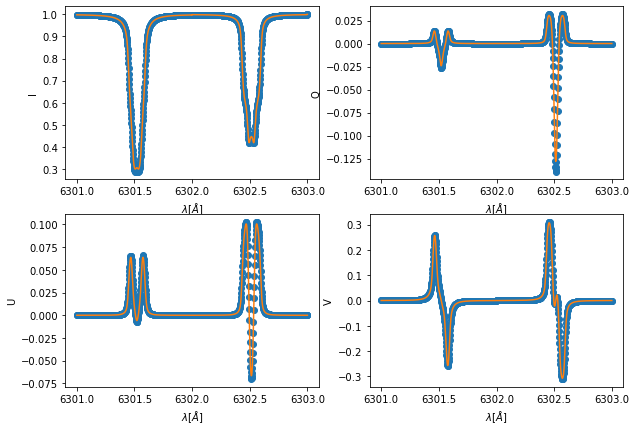

In [96]:
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll,syn[0,0,0],'o')
plt.plot(ll,fit[0,0,0])
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll,syn[0,0,1],'o')
plt.plot(ll,fit[0,0,1])
plt.subplot(223)
plt.plot(ll,syn[0,0,2],'o')
plt.plot(ll,fit[0,0,2])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll,syn[0,0,3],'o')
plt.plot(ll,fit[0,0,3])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")

In [97]:
# Let's compare the original and inferred parameters (these should be the same):

param = ['|B| [G]', 'inc [rad]', 'azi [rad]', 'vlos [km/s]', 'vDop [Angstrom]', 'eta_l', 'damping', 'S0', 'S1']
print('Name:         Real parameters -----> Inverted values')
for ii in range(9):
    print(f'{param[ii]:15}','{0:13.5f} -----> {1:13.5f}'.format(model_in[ii], model_out[0,0,ii]))

Name:         Real parameters -----> Inverted values
|B| [G]            1000.00000 ----->    1010.69218
inc [rad]             0.78540 ----->       0.77919
azi [rad]             0.52360 ----->       0.52829
vlos [km/s]           1.00000 ----->       1.00000
vDop [Angstrom]       0.02000 ----->       0.01899
eta_l                30.00000 ----->      39.88267
damping               0.10000 ----->       0.08932
S0                    0.20000 ----->       0.22974
S1                    0.80000 ----->       0.77006


#### Great! This is now a tool that we are going to use to invert various sets of the real data. But before that, let's kick off with dealing with data with noise. 

Noise is usually expressed as a fraction of continuum intensity (that is what we mean when we say, for example, $10^{-3}$ noise). 

This number is not the value of the noise (we don't know the real value of the noise, if we did, we would just correct for it), we just know the standard deviation of it. This standard deviation goes into the $\chi^2$ definittion.

In [177]:
noise_level = 1E-2 # This corresponds to SNR of 300 or 1E5 counts

noise_realization = np.random.normal(0,noise_level,4*1001).reshape(1,1,4,1001)
syn_noised = syn + noise_realization
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll,syn_noised[0,0,0])
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll,syn_noised[0,0,1])
plt.subplot(223)
plt.plot(ll,syn_noised[0,0,2])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll,syn_noised[0,0,3])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")

ValueError: operands could not be broadcast together with shapes (4,200) (1,1,4,1001) 

Now the data looks a bit more realistic. Let's fit it again:

Text(0, 0.5, 'V')

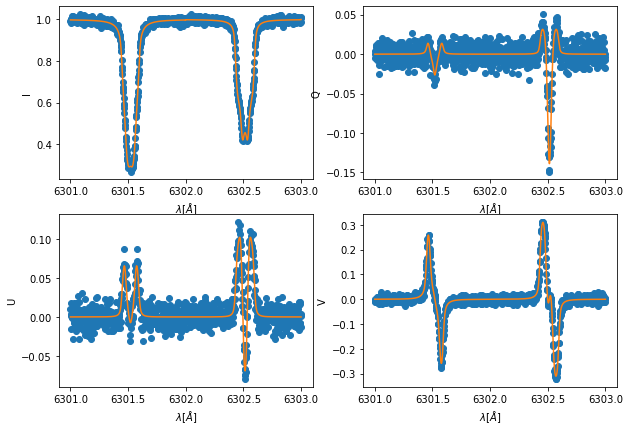

In [116]:
model_out, fit, chi2 = me.invert(model_guess, syn_noised, noise, nRandom = 5, nIter=20, chi2_thres=1E-5, verbose=False)
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll,syn_noised[0,0,0],'o')
plt.plot(ll,fit[0,0,0])
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll,syn_noised[0,0,1],'o')
plt.plot(ll,fit[0,0,1])
plt.subplot(223)
plt.plot(ll,syn_noised[0,0,2],'o')
plt.plot(ll,fit[0,0,2])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll,syn_noised[0,0,3],'o')
plt.plot(ll,fit[0,0,3])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")

In [117]:
print('Name:         Real parameters -----> Inverted values')
for ii in range(9):
    print(f'{param[ii]:15}','{0:13.5f} -----> {1:13.5f}'.format(model_in[ii], model_out[0,0,ii]))

Name:         Real parameters -----> Inverted values
|B| [G]            1000.00000 ----->     999.23365
inc [rad]             0.78540 ----->       0.78384
azi [rad]             0.52360 ----->       0.52375
vlos [km/s]           1.00000 ----->       1.00344
vDop [Angstrom]       0.02000 ----->       0.02021
eta_l                30.00000 ----->      29.32527
damping               0.10000 ----->       0.09583
S0                    0.20000 ----->       0.20122
S1                    0.80000 ----->       0.79863


The values are again very close. But 

#### Now, you might notice that the fitted values differ more from the original ones than in the noise-less case. 

It would be convenient if we could somehow quantify the uncertainties in the parameters.

Well this nice code can also do that for you! 

In [118]:
model_uncertanties = me.estimate_uncertainties(model_out, syn_noised, noise, mu=1.0)

In [119]:
print('Name  Real parameters -----> Inverted values +/- uncertainty')
for ii in range(9):
    print(f'{param[ii]:15}','{0:13.5f} -----> {1:13.5f} +/- {2:8.5f}'.format(model_in[ii], model_out[0,0,ii], model_uncertanties[0,0,ii]))

Name  Real parameters -----> Inverted values +/- uncertainty
|B| [G]            1000.00000 ----->     999.23365 +/- 60.28568
inc [rad]             0.78540 ----->       0.78384 +/-  0.08563
azi [rad]             0.52360 ----->       0.52375 +/-  0.15659
vlos [km/s]           1.00000 ----->       1.00344 +/-  0.09737
vDop [Angstrom]       0.02000 ----->       0.02021 +/-  0.00113
eta_l                30.00000 ----->      29.32527 +/-  4.82447
damping               0.10000 ----->       0.09583 +/-  0.03448
S0                    0.20000 ----->       0.20122 +/-  0.00929
S1                    0.80000 ----->       0.79863 +/-  0.01006


#### Now, you can play with adding various amounts of noise and seeing how that influences the results! 

In [113]:
model_uncertanties = me.estimate_uncertainties(model_out, syn_noised, noise, mu=1.0)

In [114]:
print('Name  Real parameters -----> Inverted values +/- uncertainty')
for ii in range(9):
    print(f'{param[ii]:15}','{0:13.5f} -----> {1:13.5f} +/- {2:8.5f}'.format(model_in[ii], model_out[0,0,ii], model_uncertanties[0,0,ii]))

Name  Real parameters -----> Inverted values +/- uncertainty
|B| [G]            1000.00000 ----->    1008.66538 +/- 132.61504
inc [rad]             0.78540 ----->       0.78387 +/-  0.19099
azi [rad]             0.52360 ----->       0.52332 +/-  0.34674
vlos [km/s]           1.00000 ----->       0.98465 +/-  0.21334
vDop [Angstrom]       0.02000 ----->       0.01962 +/-  0.00242
eta_l                30.00000 ----->      33.61819 +/- 12.56665
damping               0.10000 ----->       0.09245 +/-  0.07200
S0                    0.20000 ----->       0.20449 +/-  0.02071
S1                    0.80000 ----->       0.79455 +/-  0.02247


# Estimate the uncertainties from the pymilne package

pyMilne::dealloc: cleaning-up...
(4, 100)


Text(0, 0.5, 'V')

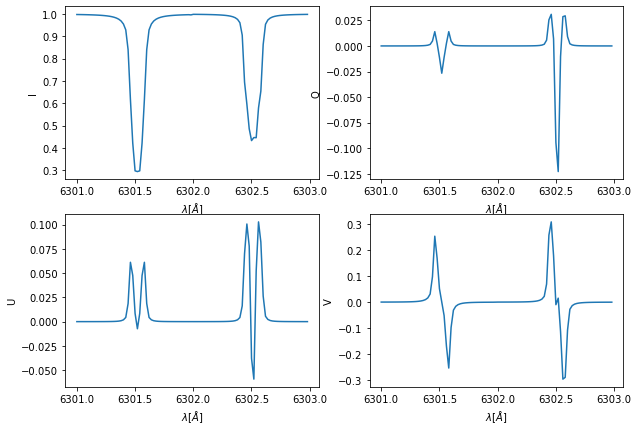

In [276]:
N_points = 100
dlambda  = 0.002*1001

# This defines the range of wavelengths we are dealing with
regions = [[np.arange(N_points, dtype='float64')*dlambda/N_points + 6301.0, None]]

# This defines which lines are taken into account, by their names (take a look at MilneEddington.py)
lines   = [6301,6302]

me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

# Now let's test whether this works:

# '|B| [G]', 'inc [rad]', 'azi [rad]', 'vlos [km/s]', 'vDop [Angstrom]', 'eta_l', 'damping', 'S0', 'S1'
model_in = np.float64([1000, np.pi/4., np.pi/6., 1.0, 0.02, 30., 0.1, 0.2, 0.8])
ll = np.squeeze(regions[0])[0]

syn = me_fwd(model_in, 1.0, me)

print(syn.shape)
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll, syn[0])
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll, syn[1])
plt.subplot(223)
plt.plot(ll, syn[2])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll, syn[3])
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")


Text(0, 0.5, 'V')

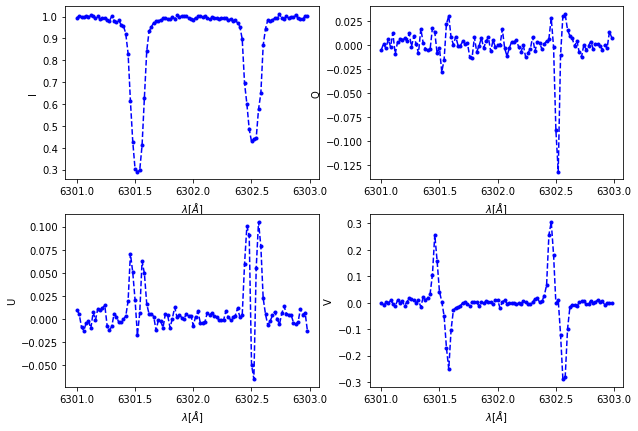

In [277]:
noise_level = np.sqrt(N_points/200)*1E-2 # This corresponds to SNR of 300 or 1E5 counts

noise_realization = np.random.normal(0,noise_level,4*N_points).reshape(1,1,4, N_points)
syn_noised = syn + noise_realization
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("I")
plt.plot(ll,syn_noised[0,0,0],'b.--')
plt.subplot(222)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Q")
plt.plot(ll,syn_noised[0,0,1],'b.--')
plt.subplot(223)
plt.plot(ll,syn_noised[0,0,2],'b.--')
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("U")
plt.subplot(224)
plt.plot(ll,syn_noised[0,0,3],'b.--')
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("V")

In [278]:
def ln_prior(params):
    '''Flat prior for theta and b_perp
    params[0] = theta
    params[1] = b_perp
    '''
    return 0

def ln_lkhood(params, data, noise_level):
    N_stokes  = 4
    model     = me_fwd(params, 1.0, me)
    data_len  = len(data[0])
    ln_lkhood = 1
    
    diff      = (data - model)
    diff2     = [[y**2 for y in x] for x in diff]
    ln_lkhood -= np.sum(diff2)/noise_level
    
    return ln_lkhood
    
def ln_post(params, data, noise_level):
    return ln_prior(params) + ln_lkhood(params, data, noise_level) 

100%|██████████| 8000/8000 [04:41<00:00, 28.47it/s]


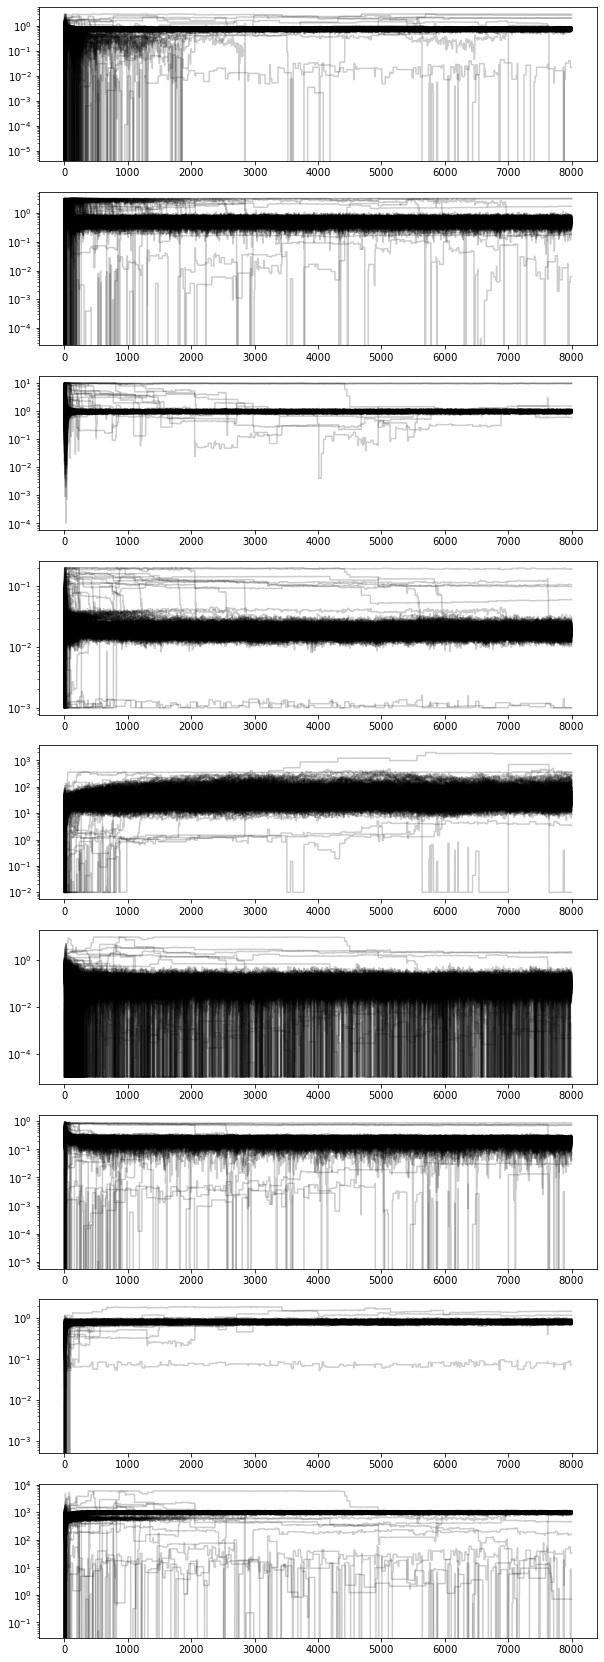

In [279]:
import os
import time


ndim = 9 # because we have nine parameters 
nwalkers = 360 # this is number of random points


data = syn_noised

from multiprocessing import Pool

#with Pool() as pool:
    
# start = time.time()
starting_params = np.zeros((nwalkers, ndim))
    
    # '|B| [G]', 'inc [rad]', 'azi [rad]', 'vlos [km/s]', 'vDop [Angstrom]', 'eta_l', 'damping', 'S0', 'S1'
param_limits = [[100, 1000], 
                [0, 1.5],
                [0, 3.1415],
                [-7, 7],
                [0., .1],
                [2, 50],
                [0.1, .8],
                [0.1, .6],
                [0.1, .8]]

for el in range(ndim):
    starting_params[:, el] = np.random.uniform(param_limits[el][0],
                                               param_limits[el][1], nwalkers) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[data, noise_level])

num_steps = 8000
pos, prob, state = sampler.run_mcmc(starting_params, num_steps, progress=True)
# end = time.time() 
# multi_time = end - start
# print("Multiprocessing took {0:.1f} seconds".format(multi_time))

plt.figure(figsize=[10,30])

for el in range(9):
    plt.subplot("91"+str(el))
    plt.plot(np.abs(sampler.chain[:, :, el].T), '-k', alpha=0.2)
    plt.yscale('log')

In [267]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))


8 CPUs


pyMilne::dealloc: cleaning-up...


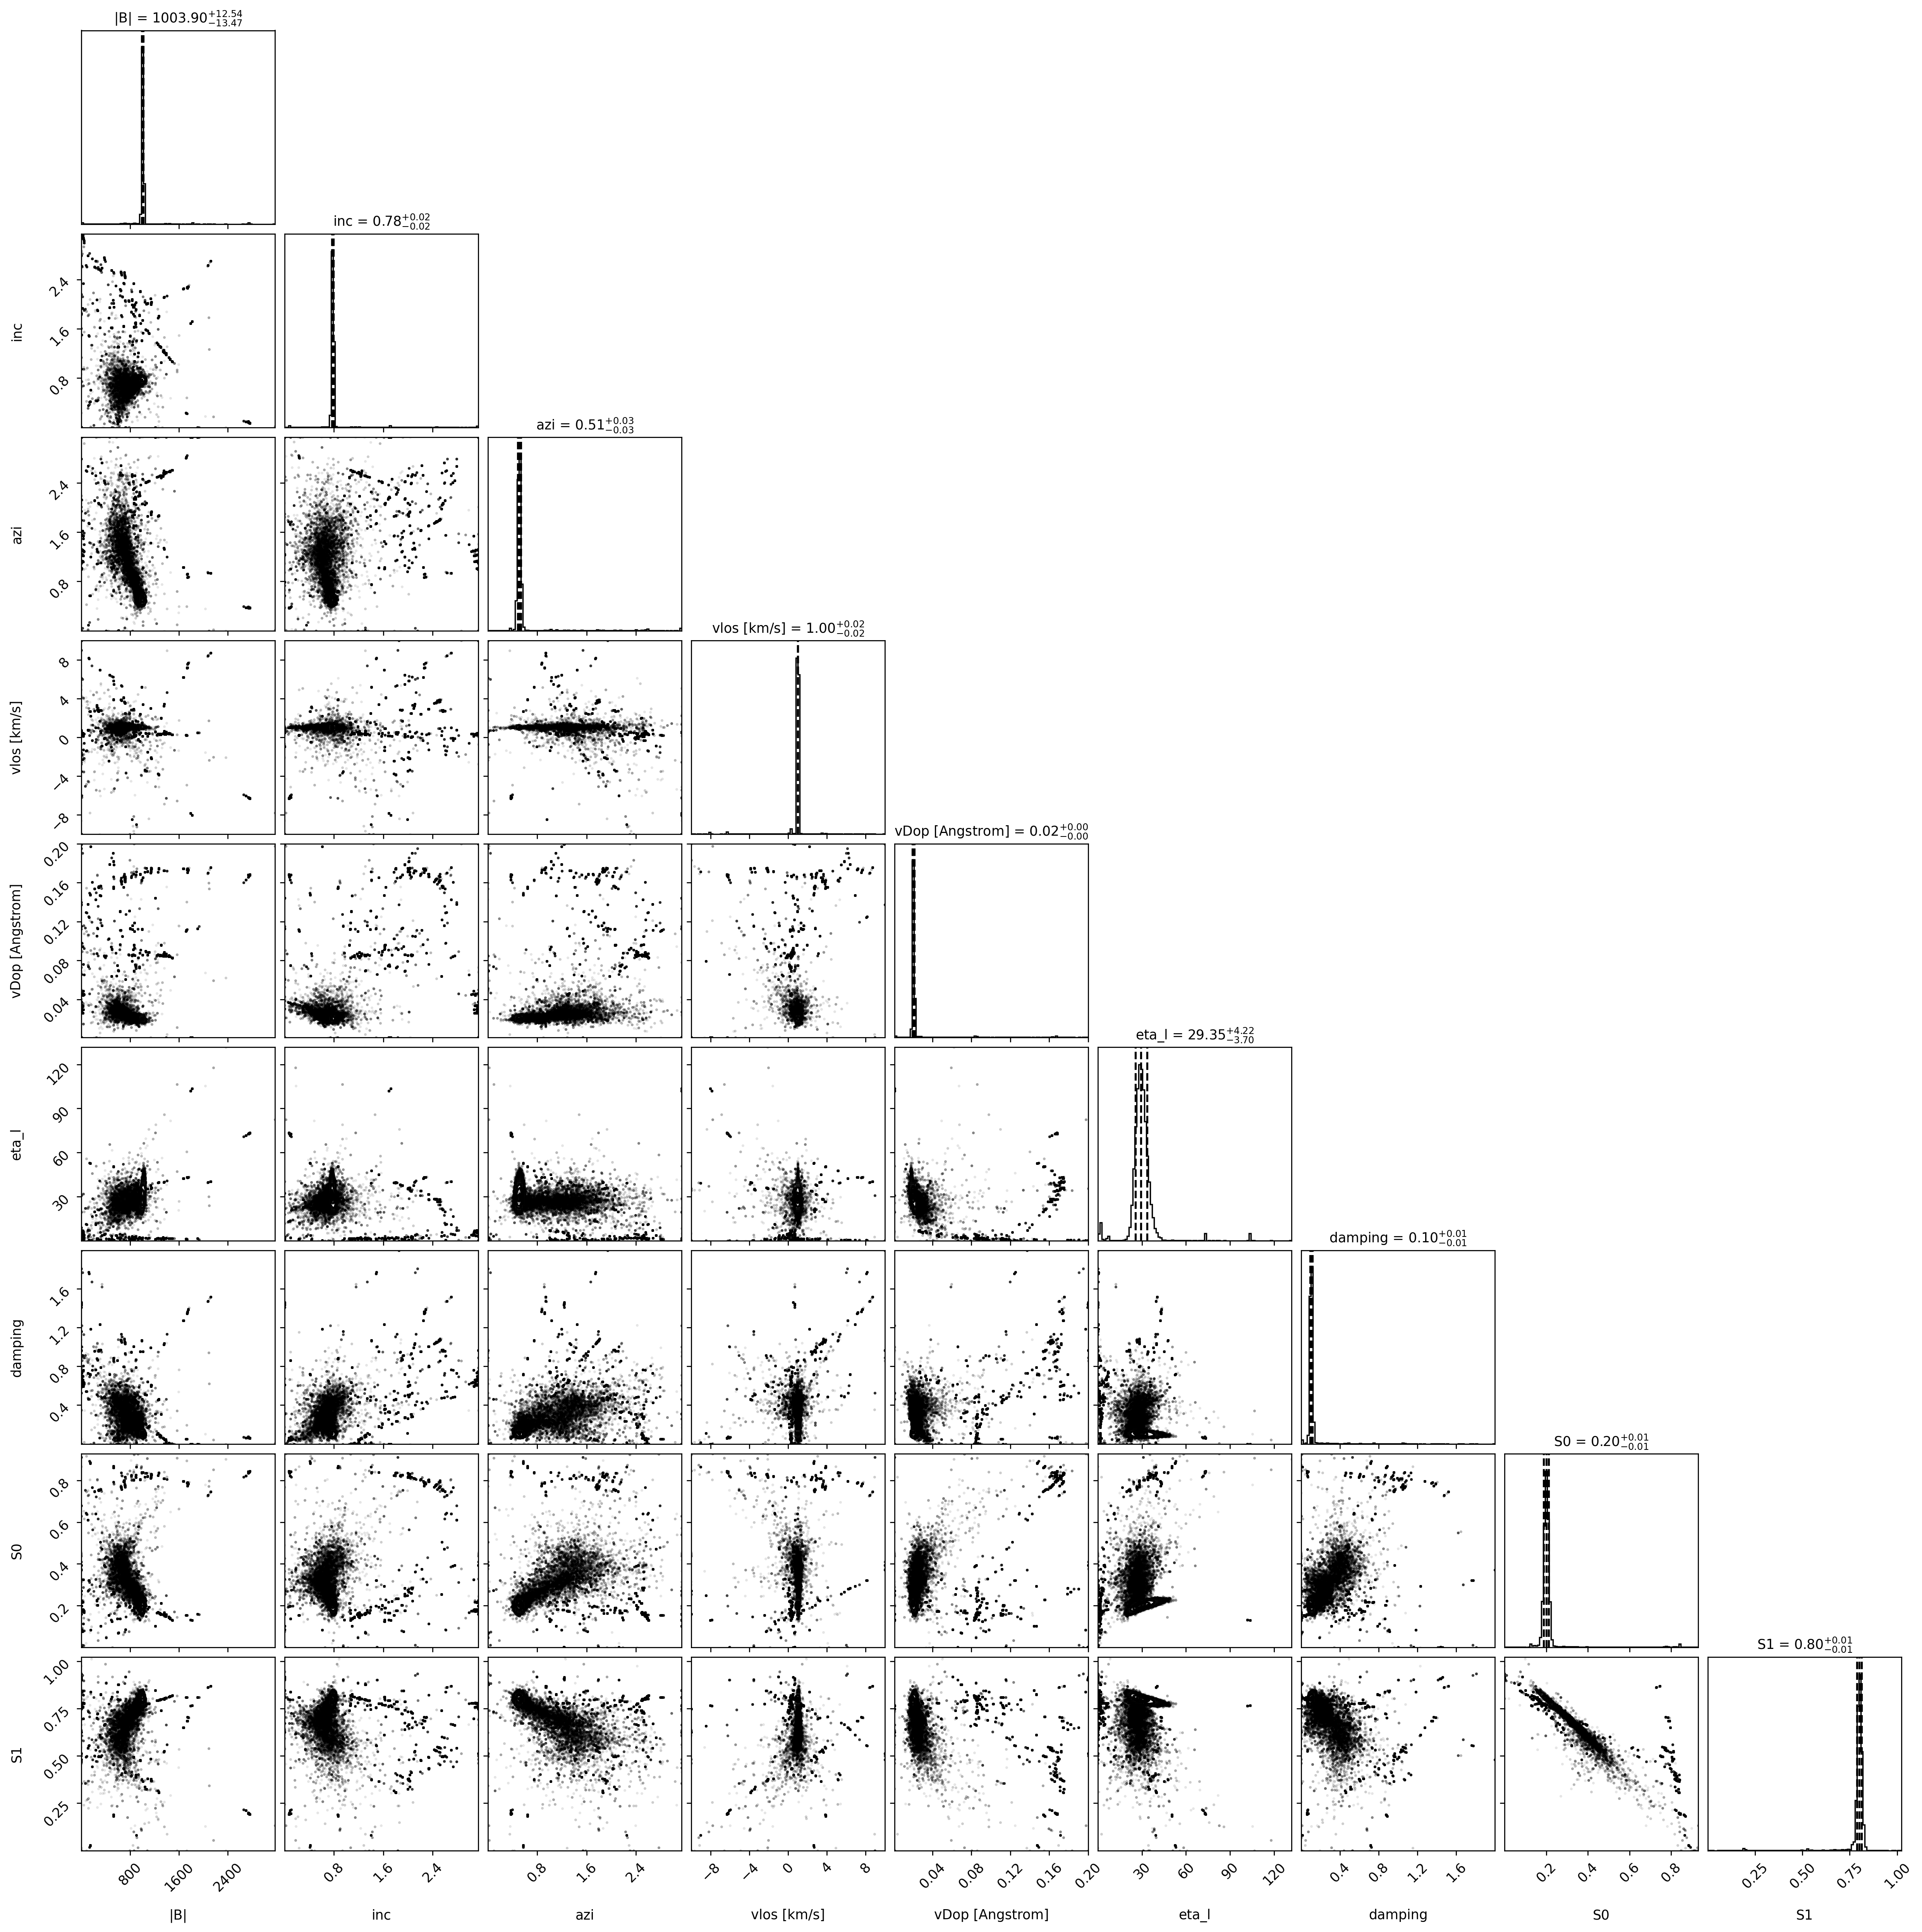

In [275]:
labels1 = ['|B|', 'inc', 'azi', 'vlos [km/s]', 'vDop [Angstrom]', 'eta_l', 'damping', 'S0', 'S1']
figure  = corner.corner(sampler.flatchain[3000:],
                       labels=labels1, bins=100,
                       quantiles=[0.16, 0.5, 0.84,],
                       show_titles=True, title_kwargs={"fontsize": 10}, )
figure.dpi=250